In [1]:
#Set to project root directory
import os
cwd = os.path.abspath("..")
os.chdir(cwd)

In [2]:
pwd

'/home/blansdel/projects/schwarz/decoder'

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle 

from collections import defaultdict
from scipy.stats import ranksums
from scipy.stats import chi2_contingency

In [4]:
with open('data/processed/day7results_predcounts.pkl', 'rb') as f:
    day7results = pickle.load(f)

with open('data/processed/day9results_predcounts.pkl', 'rb') as f:
    day9results = pickle.load(f)

In [5]:
def present_results(results_d7, results_d9, title = None):
    results = pd.concat([results_d7, results_d9])
    results['Session'] = results['Session_trial'].str.split('_').str[0]
    results['Pred_reward_trial'] = (results['Prop_pred_reward_trial'] > 0.5).astype(float)

    prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
    prediction_counts['Previously_rewarded'] = 36-prediction_counts['Reward']

    fig, axes = plt.subplots(2,2, figsize = (10, 10), sharey = True)
    if title:
        fig.suptitle(f'Time points: {title}')
    for idx, session in enumerate(['7', '9']):
        axes[0,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Pred_reward_trial,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[0,idx].set_xlabel('treatment')
        axes[0,idx].set_ylabel('Predicted reward trials (/36)')
        axes[0,idx].set_title(f'Day {session}')

    for idx, session in enumerate(['7', '9']):
        axes[1,idx].bar(x = [1,2,3], 
                    height = prediction_counts[prediction_counts.Session == session].Previously_rewarded,
                    tick_label = prediction_counts[prediction_counts.Session == session].treatment)
        axes[1,idx].set_xlabel('treatment')
        axes[1,idx].set_ylabel('Previously rewarded trials (/36)')

    return prediction_counts

def compute_stats(prediction_counts, title = ''):
    pairs = [('Clonidine', 'Control'),('Clonidine', 'Idazoxan'),('Control', 'Idazoxan')]
    days = ['7', '9']
    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Pred_reward_trial'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Pred_reward_trial'].values[0]
            if (row1_val == row2_val == 36) or (row1_val == row2_val == 36):
                pval = -1
            else:
                c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
                pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_pred_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    test_results = np.zeros((len(pairs), len(days)))
    for i,pair in enumerate(pairs):
        for j,day in enumerate(days):
            row1_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[0])]['Previously_rewarded'].values[0]
            row2_val = prediction_counts[(prediction_counts.Session == day) & (prediction_counts.treatment == pair[1])]['Previously_rewarded'].values[0]
            c_table = [[row1_val, 36-row1_val], [row2_val, 36-row2_val]]
            pval = chi2_contingency(c_table)[1]
            test_results[i,j] = pval
    test_results_reward_trials = pd.DataFrame(test_results, index = pairs, columns = days)

    print(title)
    print('Test reward prediction comparisons')
    print(test_results_pred_trials)
    print(title)
    print('Test rewarded trials comparisons')
    print(test_results_reward_trials)
    return test_results_pred_trials, test_results_reward_trials

### Summarize predictions on reversal days

/tmp/ipykernel_2919290/3398547075.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()
/tmp/ipykernel_2919290/3398547075.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prediction_counts = results.groupby(['treatment', 'Session'])['Pred_reward_trial', 'Reward'].sum().reset_index()


(201, 240)
Test reward prediction comparisons
                              7         9
(Clonidine, Control)   0.013308  0.119782
(Clonidine, Idazoxan)  0.024449  0.043170
(Control, Idazoxan)    1.000000  0.811070
(201, 240)
Test rewarded trials comparisons
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475
(201, 280)
Test reward prediction comparisons
                              7         9
(Clonidine, Control)   0.038056  1.000000
(Clonidine, Idazoxan)  0.000048  0.153276
(Control, Idazoxan)    0.058464  0.094264
(201, 280)
Test rewarded trials comparisons
                              7         9
(Clonidine, Control)   0.144127  0.468304
(Clonidine, Idazoxan)  1.000000  1.000000
(Control, Idazoxan)    0.085886  0.336475


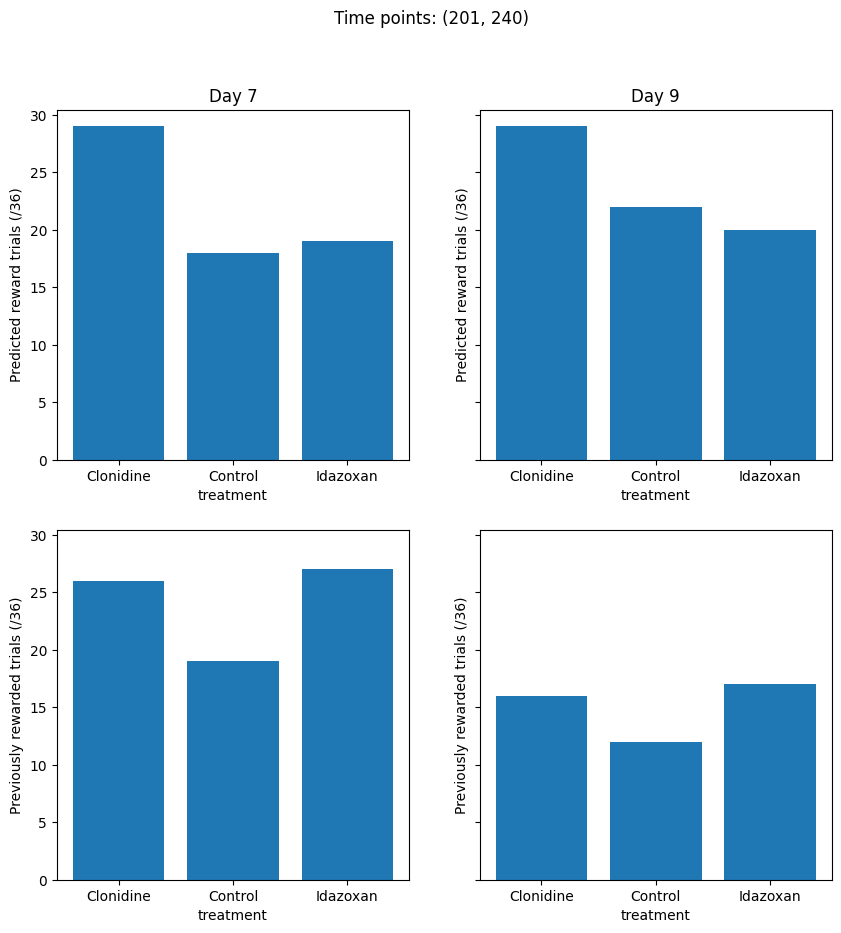

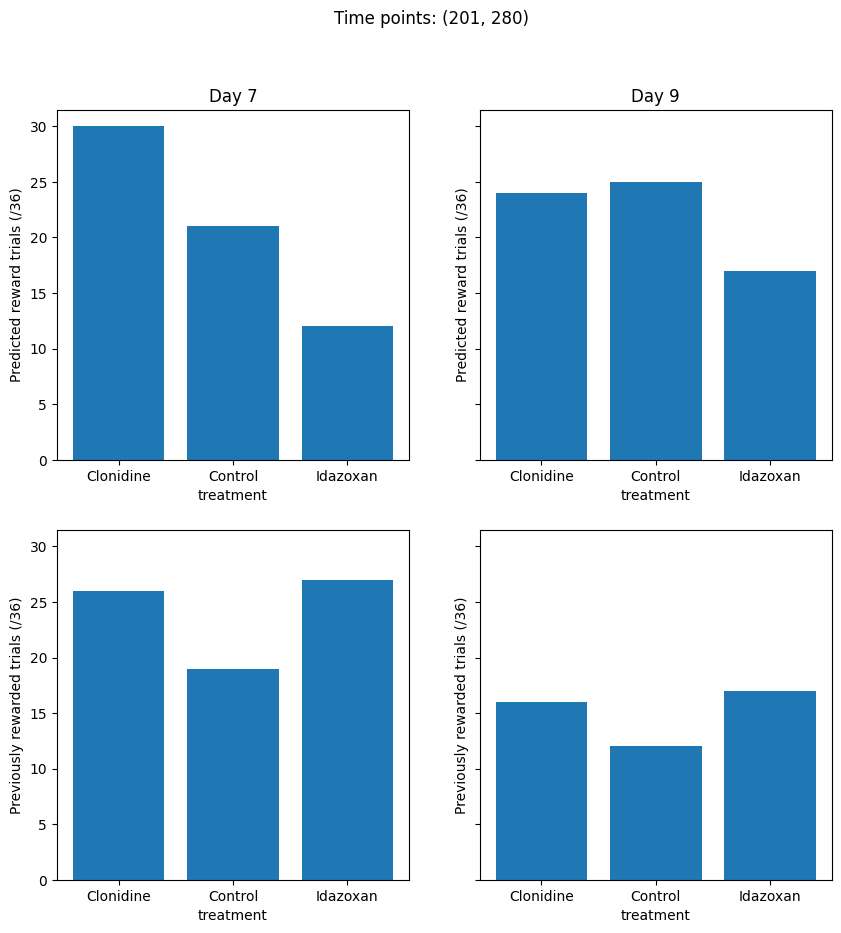

In [13]:
window_keys = []
for rd7, rd9 in zip(day7results.keys(), day9results.keys()):
    if rd7[1][0] != 201: continue
    window_keys.append((rd7, rd9))
    prediction_counts = present_results(day7results[rd7], day9results[rd9], title = rd7[1])
    test_results_pred_trials, test_results_reward_trials = compute_stats(prediction_counts, title = rd7[1])

In [7]:
prediction_counts

,treatment,Session,Pred_reward_trial,Reward,Previously_rewarded
0,Clonidine,7,30.0,10.0,26.0
1,Clonidine,9,24.0,20.0,16.0
2,Control,7,21.0,17.0,19.0
3,Control,9,25.0,24.0,12.0
4,Idazoxan,7,12.0,9.0,27.0
5,Idazoxan,9,17.0,19.0,17.0


### Prediction details

The dataframes that house all of the decoder results are here. Each row is a trial. Some columns are session level (hence repeated), some are per trial. Columns are as follows:

* treatment: condition, one of control, clonidine, idazoxan
* animal: animal ID
* val_accuracy: validation accuracy of decoder (cross validation in training days, pre-reversal days 2,6)
* test_accuracy: accuracy of day 7/day 9
* prop_reward_pred_val: proportion of trials predicted reward in validation set
* prop_reward_pred_test: proportion of trials predicted reward in test set
* prop_reward: proportion of trials rewarded in validation set
* prop_reward_test: proportion of trials rewarded in test set
* val_f1: validation F1 score
* test_f1: test F1 score
* test_tp: test TP proportion
* test_tn: test TN proportion
* test_fp: test FP proportion
* test_fn: test FN proportion
* val_tp: validation TP proportion
* val_tn: validation TN proportion
* val_fp: validation FP proportion
* val_fn: validation FN proportion
* Session_trial: Concatenate session and trial number
* Reward: whether this trial was rewarded or not
* Prop_pred_reward_trial: whether this trial was predicted reward or not

(201, 240) decoder window:

In [15]:
print("Day 7")
day7results[window_keys[0][0]]

Day 7


,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_1,0.0,1.0
1,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_10,0.0,1.0
2,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_11,1.0,1.0
3,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_12,0.0,0.0
4,Control,1,0.887179,0.544872,0.761752,0.794872,0.708333,0.583333,0.920058,0.669767,...,0.083333,0.333333,0.121795,0.676282,0.206197,0.085470,0.032051,7_2,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.800000,0.250000,1.000000,1.000000,0.791667,0.250000,0.883721,0.400000,...,0.000000,0.750000,0.000000,0.791667,0.000000,0.208333,0.000000,7_5,0.0,1.0
8,Clonidine,F4,0.800000,0.250000,1.000000,1.000000,0.791667,0.250000,0.883721,0.400000,...,0.000000,0.750000,0.000000,0.791667,0.000000,0.208333,0.000000,7_6,0.0,1.0
9,Clonidine,F4,0.800000,0.250000,1.000000,1.000000,0.791667,0.250000,0.883721,0.400000,...,0.000000,0.750000,0.000000,0.791667,0.000000,0.208333,0.000000,7_7,1.0,1.0
10,Clonidine,F4,0.800000,0.250000,1.000000,1.000000,0.791667,0.250000,0.883721,0.400000,...,0.000000,0.750000,0.000000,0.791667,0.000000,0.208333,0.000000,7_8,0.0,1.0


In [16]:
print("Day 9")
day9results[window_keys[0][1]]

Day 9


,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,...,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9_1,0.0,0.000000
1,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,...,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9_10,1.0,0.000000
2,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,...,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9_11,1.0,0.000000
3,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,...,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9_12,0.0,0.487179
4,Control,1,0.893333,0.480769,0.780983,0.311966,0.708333,0.750000,0.925395,0.511066,...,0.209402,0.040598,0.478632,0.689103,0.199786,0.091880,0.019231,9_2,1.0,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_5,1.0,1.000000
8,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_6,0.0,1.000000
9,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_7,1.0,1.000000
10,Clonidine,F4,0.800000,0.583333,1.000000,1.000000,0.791667,0.583333,0.883721,0.736842,...,0.000000,0.416667,0.000000,0.791667,0.000000,0.208333,0.000000,9_8,1.0,1.000000


For comparison, if interested, here are the results for the (201, 280) frames-based decoder

In [18]:
print("Day 7")
day7results[window_keys[1][0]]

Day 7


,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.899241,0.42616,0.787447,0.642405,0.708333,0.583333,0.929478,0.531842,...,0.100211,0.316456,0.257384,0.695148,0.199367,0.092300,0.013186,7_1,0.0,1.000000
1,Control,1,0.899241,0.42616,0.787447,0.642405,0.708333,0.583333,0.929478,0.531842,...,0.100211,0.316456,0.257384,0.695148,0.199367,0.092300,0.013186,7_10,0.0,1.000000
2,Control,1,0.899241,0.42616,0.787447,0.642405,0.708333,0.583333,0.929478,0.531842,...,0.100211,0.316456,0.257384,0.695148,0.199367,0.092300,0.013186,7_11,1.0,0.139241
3,Control,1,0.899241,0.42616,0.787447,0.642405,0.708333,0.583333,0.929478,0.531842,...,0.100211,0.316456,0.257384,0.695148,0.199367,0.092300,0.013186,7_12,0.0,0.000000
4,Control,1,0.899241,0.42616,0.787447,0.642405,0.708333,0.583333,0.929478,0.531842,...,0.100211,0.316456,0.257384,0.695148,0.199367,0.092300,0.013186,7_2,1.0,0.177215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.788354,0.25000,0.987869,1.000000,0.791667,0.250000,0.876111,0.400000,...,0.000000,0.750000,0.000000,0.779536,0.000000,0.208333,0.012131,7_5,0.0,1.000000
8,Clonidine,F4,0.788354,0.25000,0.987869,1.000000,0.791667,0.250000,0.876111,0.400000,...,0.000000,0.750000,0.000000,0.779536,0.000000,0.208333,0.012131,7_6,0.0,1.000000
9,Clonidine,F4,0.788354,0.25000,0.987869,1.000000,0.791667,0.250000,0.876111,0.400000,...,0.000000,0.750000,0.000000,0.779536,0.000000,0.208333,0.012131,7_7,1.0,1.000000
10,Clonidine,F4,0.788354,0.25000,0.987869,1.000000,0.791667,0.250000,0.876111,0.400000,...,0.000000,0.750000,0.000000,0.779536,0.000000,0.208333,0.012131,7_8,0.0,1.000000


In [19]:
print("Day 9")
day9results[window_keys[1][1]]

Day 9


,treatment,animal,val_accuracy,test_accuracy,prop_reward_pred_val,prop_reward_pred_test,prop_reward,prop_reward_test,val_f1,test_f1,...,test_tn,test_fp,test_fn,val_tp,val_tn,val_fp,val_fn,Session_trial,Reward,Prop_pred_reward_trial
0,Control,1,0.871899,0.550633,0.764241,0.501055,0.708333,0.750000,0.909026,0.640809,...,0.149789,0.100211,0.349156,0.669304,0.19673,0.094937,0.039030,9_1,0.0,0.000000
1,Control,1,0.871899,0.550633,0.764241,0.501055,0.708333,0.750000,0.909026,0.640809,...,0.149789,0.100211,0.349156,0.669304,0.19673,0.094937,0.039030,9_10,1.0,0.303797
2,Control,1,0.871899,0.550633,0.764241,0.501055,0.708333,0.750000,0.909026,0.640809,...,0.149789,0.100211,0.349156,0.669304,0.19673,0.094937,0.039030,9_11,1.0,0.683544
3,Control,1,0.871899,0.550633,0.764241,0.501055,0.708333,0.750000,0.909026,0.640809,...,0.149789,0.100211,0.349156,0.669304,0.19673,0.094937,0.039030,9_12,0.0,0.759494
4,Control,1,0.871899,0.550633,0.764241,0.501055,0.708333,0.750000,0.909026,0.640809,...,0.149789,0.100211,0.349156,0.669304,0.19673,0.094937,0.039030,9_2,1.0,0.506329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,Clonidine,F4,0.794937,0.585443,0.994726,0.995781,0.791667,0.583333,0.880425,0.737475,...,0.003165,0.413502,0.001055,0.786392,0.00000,0.208333,0.005274,9_5,1.0,1.000000
8,Clonidine,F4,0.794937,0.585443,0.994726,0.995781,0.791667,0.583333,0.880425,0.737475,...,0.003165,0.413502,0.001055,0.786392,0.00000,0.208333,0.005274,9_6,0.0,1.000000
9,Clonidine,F4,0.794937,0.585443,0.994726,0.995781,0.791667,0.583333,0.880425,0.737475,...,0.003165,0.413502,0.001055,0.786392,0.00000,0.208333,0.005274,9_7,1.0,1.000000
10,Clonidine,F4,0.794937,0.585443,0.994726,0.995781,0.791667,0.583333,0.880425,0.737475,...,0.003165,0.413502,0.001055,0.786392,0.00000,0.208333,0.005274,9_8,1.0,1.000000
